In [4]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

#from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
#import mitequinox.sigp as sp



In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [8]:
path = '/Users/zcaspar/codes/mit4320/'
dsL = xr.open_dataset(path+'binned_Lcov.nc')
dsE = xr.open_dataset(path+'binned_Ecov.nc')

In [10]:
dsL = dsL.isel(lags=slice(0,None,3)).sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))

In [11]:
print(dsL,dsE)

<xarray.Dataset>
Dimensions:   (lags: 321, lat_bins: 60, lon_bins: 179)
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0 59.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr        (lat_bins, lon_bins, lags) float64 ...
    ri        (lat_bins, lon_bins, lags) float64 ...
Attributes:
    binsize:  2 <xarray.Dataset>
Dimensions:   (lags: 321, lat_bins: 119, lon_bins: 359)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bins  (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    Crr       (lags, lon_bins, lat_bins) float64 ...


Text(0.5, 1.0, 'Lagrangian amplitude')

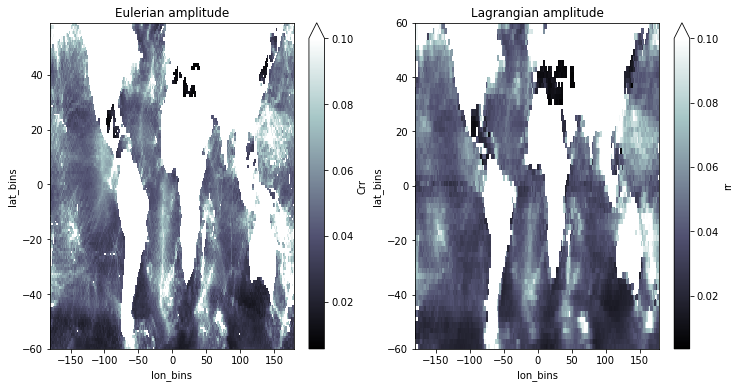

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
np.sqrt(dsE.isel(lags=0).Crr).plot(ax=axs[0],vmax=0.1,cmap='bone',y='lat_bins')
axs[0].set_title('Eulerian amplitude')
np.sqrt(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.1,cmap='bone',y='lat_bins')
axs[1].set_title('Lagrangian amplitude')

Text(0.5, 1.0, 'Lagrangian real-real covariance')

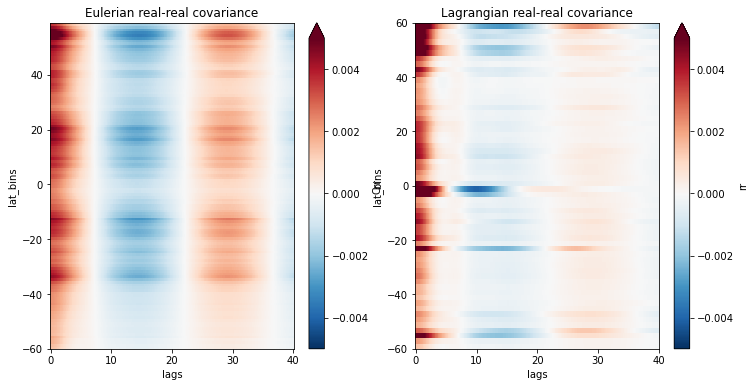

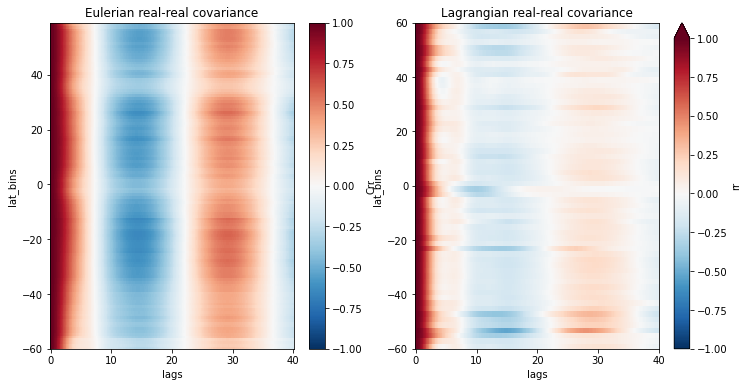

In [43]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').Crr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')


fig,axs = plt.subplots(1,2,figsize=(12,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).Crr.plot(y='lat_bins',ax=axs[0],vmax=1)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')



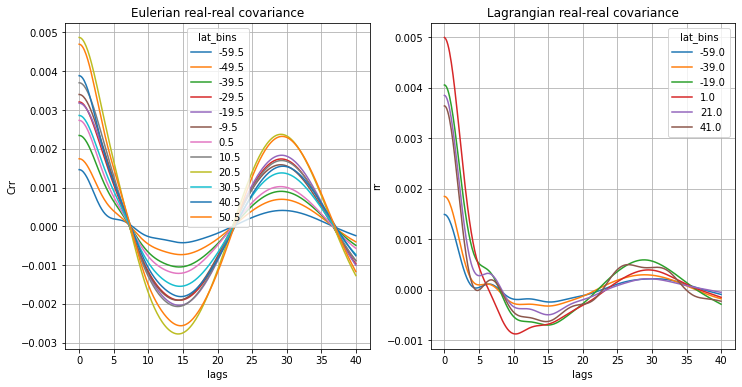

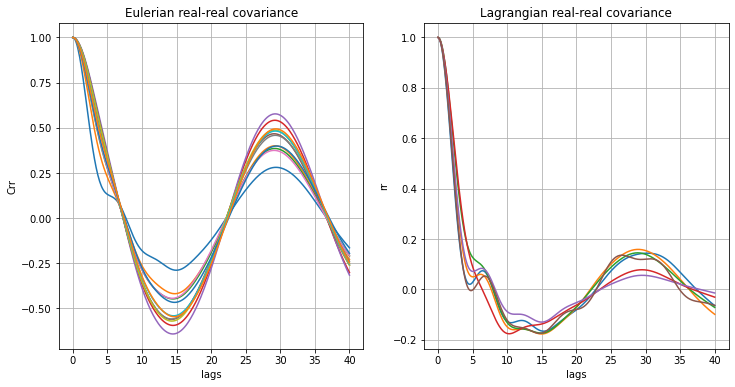

In [40]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').Crr.isel(lat_bins=slice(0,None,10)).plot(hue='lat_bins',ax=axs[0],add_legend=True)
dsL.mean('lon_bins').rr.isel(lat_bins=slice(0,None,10)).plot(hue='lat_bins',ax=axs[1],add_legend=True)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid()

fig,axs = plt.subplots(1,2,figsize=(12,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).Crr.isel(lat_bins=slice(0,None,10)).plot(hue='lat_bins',ax=axs[0],add_legend=False)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.isel(lat_bins=slice(0,None,10)).plot(hue='lat_bins',ax=axs[1],add_legend=False)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid()